In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
import pickle
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from google.colab import drive
import copy
drive.mount('/content/gdrive')


# The following code in the cell loads the dataset, and forms the training data. Then preprocesses the sentences and tokenizes the all the words in the dataset 
# and pads the sentences and represents each sentence by the token values of the words in the sentence


with open("/content/gdrive/My Drive/DL_Project/sentence_list_and_reference_data_revision2.pickle","rb") as f:
  example_dict = pickle.load(f)
  list_data,all_sentences=example_dict


for i in range(len(all_sentences)):
  all_sentences[i]="<start> "+all_sentences[i]+" <end>"

with open("/content/gdrive/My Drive/DL_Project/training_indexes_from_total_data.pickle","rb") as f:
  training_indexes_in_total = pickle.load(f)

all_sentences_training=[all_sentences[i] for i in training_indexes_in_total]
  
tokenizer = Tokenizer(filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_sentences_training)

sentences_to_encode = all_sentences_training



encoded_sentences = tokenizer.texts_to_sequences(sentences_to_encode)

word_to_index=tokenizer.word_index
index_to_word = dict((v,k) for k,v in word_to_index.items())

word_to_index['<pad>']=0
index_to_word[0]='<pad>'

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(encoded_sentences, padding='post')

vocab_size = max(max(i) for i in encoded_sentences) + 1


     |████████████████████████████████| 332.1MB 47kB/s 
     |████████████████████████████████| 419kB 44.4MB/s 
     |████████████████████████████████| 61kB 27.8MB/s 
     |████████████████████████████████| 3.0MB 31.4MB/s 


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Here we are loading the 2048-dimensional image representation of all the images in the dataset and forming a list of 2048 dimensional representation of images that belong to training set 


# We have 30,000 training examples for this project. Containing 6000 unique images with more than one captions for each image. 

with open("/content/gdrive/My Drive/DL_Project/imagenet_names_vectors_ordered_revision2.pkl","rb") as f:
  example_dict_2 = pickle.load(f)
  imagenet_names,imagenet_vectors=example_dict_2


img_vec_names=[imagenet_names[i] for i in training_indexes_in_total]
img_vecs=[imagenet_vectors[i] for i in training_indexes_in_total]
sen_vecs=copy.copy(cap_vector)



In [0]:
import random


#The model for generating captions from images is very similar to the classical image captioning example given by tensorflow tutorials, However, it is not the same. The 
# classical image captioning example uses attention model to infer captions for the images. But as we also have to infer images given the captions at a later stage of the project
# we cannot use attention to predict the next word in the sequence, instead we resort to using the entire image itself. Here the encoder class encodes the 2048 image tensor into a 300-dimensional
# embedding of the image.




class CNN_Encoder(tf.keras.Model):
    
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x=tf.expand_dims(x,1)
        x = self.fc(x)
        x = tf.nn.relu(x)
        x=tf.reshape(x,[tf.shape(x)[0],300])
        return x

      
      
      

#The decoder function recieves the image embedding along with word token value. It converts each word token value into a 300 dimensional embedding and concatenates the image embedding with word 
# embeddings and pass them to the recurrent neural network layer followed by a fully connected neural network layer.      

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(5581)
    self.embedding = tf.keras.layers.Embedding(5581, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',stateful=True,batch_input_shape=(1,1, 300))
    
  def call(self, x, features, flags_embedding=1):
    x = self.embedding(x)
    if flags_embedding==0:
      return x
    x = tf.concat([tf.expand_dims(features, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state


#In the training step, we one by one keep incrementing the number of words being passed along with the image embedding to the model to predict the next word as described in the project report.
  
def train_step(image_vector_for_processing, label_sentence):
  
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * 1, 1)
  loss = 0
  
  with tf.GradientTape() as tape:
      features = encoder(image_vector_for_processing)
      
      for i in range(1, label_sentence.shape[1]):
          predictions, hidden = decoder(dec_input, features)
          loss += loss_function(label_sentence[:, i], predictions)
          dec_input = tf.expand_dims(label_sentence[:, i], 1)
  total_loss = (loss / int(label_sentence.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss, total_loss
  

embedding_dim=300
units=516
vocab_size=5581


encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

adam_lr=0.0001
optimizer = tf.keras.optimizers.Adam(lr=adam_lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')




#Calculating the loss for each prediction using the below function accordingly.

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


num_steps=30000
batch=1

adam_lr=0.0001

loss_plot = []


#Create Check-Points in the intended file, as you will need this checkpoint file to be restored when running the other program to get similar words, similar images and to infer images from captions

checkpoint_path_extension = "/content/gdrive/My Drive/DL_Project/Revised_training_seq/final"
ckpt_extension=tf.train.Checkpoint(encoder=encoder,decoder=decoder,optimizer = optimizer)
ckpt_manager_extension=tf.train.CheckpointManager(ckpt_extension, checkpoint_path_extension, max_to_keep=3)


for epoch in range(0,10):
    total_loss = 0
    z = list(zip(img_vecs, sen_vecs))
    random.shuffle(z)
    img_vecs, sen_vecs = zip(*z)
    img_vecs=np.asarray(list(img_vecs))
    sen_vecs=np.asarray(list(sen_vecs))
    
    for i in range(0,30000):
        
        img_vecs_batch=img_vecs[i:i+1]
        sen_vecs_batch=sen_vecs[i:i+1]
        
        batch_loss, t_loss = train_step(img_vecs_batch, sen_vecs_batch)
        total_loss += t_loss
        print("Epoch-",epoch+1," Batch-",i," loss-",batch_loss.numpy() / int(sen_vecs_batch.shape[1]))
        
        if i % 100 == 0:
            ckpt_manager_extension.save()
    loss_plot.append(total_loss / num_steps)
    print("epoch-",epoch+1)
    print("loss for above mentioned epoch-",total_loss/num_steps)
    




"\n\n\nfor epoch in range(0,10):\n    total_loss = 0\n    z = list(zip(img_vecs, sen_vecs))\n    random.shuffle(z)\n    img_vecs, sen_vecs = zip(*z)\n    img_vecs=np.asarray(list(img_vecs))\n    sen_vecs=np.asarray(list(sen_vecs))\n    \n    for i in range(0,30000):\n        \n        img_vecs_batch=img_vecs[i:i+1]\n        sen_vecs_batch=sen_vecs[i:i+1]\n        \n        batch_loss, t_loss = train_step(img_vecs_batch, sen_vecs_batch)\n        total_loss += t_loss\n\n        if i % 1 == 0:\n            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, i, batch_loss.numpy() / int(sen_vecs_batch.shape[1])))\n        if i % 100 == 0:\n            ckpt_manager_extension.save()\n    loss_plot.append(total_loss / num_steps)\n    print('Epoch {} Loss {:.6f}'.format(epoch + 1,total_loss/num_steps))\n\n\n"

In [0]:
#this function carries out the test procedure as described in the project report for each image given to it as input.

def evaluate(image):
    
    features = encoder(image)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden = decoder(dec_input, features)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [0]:
!unzip "/content/gdrive/My Drive/DL_Project/Flickr8k_Dataset.zip"

Archive:  /content/gdrive/My Drive/DL_Project/Flickr8k_Dataset.zip
   creating: Flicker8k_Dataset/
  inflating: Flicker8k_Dataset/1000268201_693b08cb0e.jpg  
   creating: __MACOSX/
   creating: __MACOSX/Flicker8k_Dataset/
  inflating: __MACOSX/Flicker8k_Dataset/._1000268201_693b08cb0e.jpg  
  inflating: Flicker8k_Dataset/1001773457_577c3a7d70.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1001773457_577c3a7d70.jpg  
  inflating: Flicker8k_Dataset/1002674143_1b742ab4b8.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1002674143_1b742ab4b8.jpg  
  inflating: Flicker8k_Dataset/1003163366_44323f5815.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1003163366_44323f5815.jpg  
  inflating: Flicker8k_Dataset/1007129816_e794419615.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1007129816_e794419615.jpg  
  inflating: Flicker8k_Dataset/1007320043_627395c3d8.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._1007320043_627395c3d8.jpg  
  inflating: Flicker8k_Dataset/1009434119_febe49276a.jpg  
  in

In [0]:
#loading test image 2048-dimensional representation recieved from the pre-trained InceptionV3 network. 

with open("/content/gdrive/My Drive/DL_Project/test_image_vectors_and_names_revised.pkl","rb") as f:
  example_dict = pickle.load(f)
  test_image_vectors,test_image_names=example_dict

In [0]:
print(len(test_image_names))
max_length= max(len(t) for t in encoded_sentences)

list_names=[]
list_results=[]
list_index=[]

for i in range(0,1000,5):
  list_index.append(i)
  list_names.append(test_image_names[i])
  list_results.append(evaluate([test_image_vectors[i]]))



1000


Predicted Caption- a man in a black shirt and a black hat


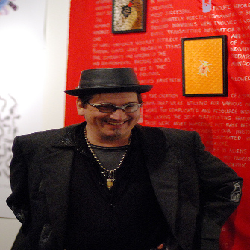

In [0]:
#Showing a few results we got while generating captions using lemmatized tokens.

from tensorflow.python.keras.preprocessing import image

a=list_results[197][:-1]
a=" ".join(a)
print("Predicted Caption-",a)
image.load_img("/content/Flicker8k_Dataset/2167644298_100ca79f54.jpg",target_size=(250, 250))



Predicted Caption- a group of person be stand in front of a store


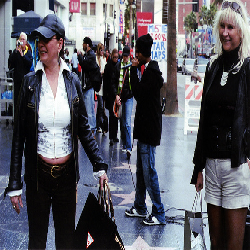

In [0]:


a=list_results[191][:-1]
a=" ".join(a)
print("Predicted Caption-",a)

image.load_img("/content/Flicker8k_Dataset/2182488373_df73c7cc09.jpg", target_size=(250, 250))


Predicted Caption- a dog run through the grass


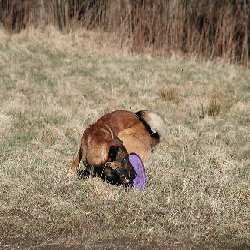

In [0]:
a=list_results[163][:-1]
a=" ".join(a)
print("Predicted Caption-",a)
image.load_img("/content/Flicker8k_Dataset/430173345_86388d8822.jpg", target_size=(250, 250))

Predicted Caption- a football player in red and white jersey be tackle


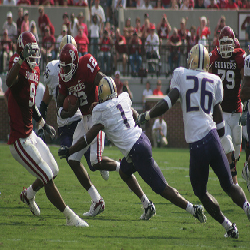

In [0]:
a=list_results[74][:-1]
a=" ".join(a)
print("Predicted Caption-",a)

image.load_img("/content/Flicker8k_Dataset/241346508_0b3907a95b.jpg", target_size=(250, 250))